In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam

from sklearn.model_selection import train_test_split


In [2]:
class FaceSpoofingModel(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(FaceSpoofingModel, self).__init__()
        mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(mobilenet.children())[:-1])
        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(576, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        
        return out

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FaceSpoofingModel(num_classes=2).to(device)
print(model)

FaceSpoofingModel(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2

In [4]:
DATASET_DIR = "Face Dataset\\"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(DATASET_DIR, transform=transform)
targets = [label for _, label in full_dataset.samples]  # class labels

# Train/val/test split with stratification
train_idx, temp_idx, _, temp_targets = train_test_split(
    range(len(targets)), targets,
    test_size=0.5, stratify=targets, random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.67, stratify=temp_targets, random_state=42
)  
# 0.1 val, 0.4 test (relative to full dataset)

# Wrap into Subsets
train_set = Subset(full_dataset, train_idx)
val_set = Subset(full_dataset, val_idx)
test_set = Subset(full_dataset, test_idx)

print(f"Train {len(train_set)}, Val {len(val_set)}, Test {len(test_set)}")

Train 702, Val 231, Test 471


In [5]:
from collections import Counter

def get_class_distribution(dataset, split_name=""):
    # dataset is a Subset from random_split
    targets = [dataset.dataset.targets[i] for i in dataset.indices]
    counter = Counter(targets)
    print(f"\nClass distribution in {split_name}:")
    for class_idx, count in counter.items():
        class_name = dataset.dataset.classes[class_idx]
        print(f"  {class_name}: {count}")

# Example usage:
get_class_distribution(train_set, "Train")
get_class_distribution(val_set, "Val")
get_class_distribution(test_set, "Test")



Class distribution in Train:
  Fake Filtered: 450
  Data Liveness All: 252

Class distribution in Val:
  Data Liveness All: 83
  Fake Filtered: 148

Class distribution in Test:
  Data Liveness All: 170
  Fake Filtered: 301


In [6]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [7]:
# Example to check one batch
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Image batch shape: {images.size()}")
print(f"{labels}")

Image batch shape: torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1])


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_corrects = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        epoch_corrects += torch.sum(preds == labels.data)
    epoch_loss /= len(train_set)
    epoch_acc = epoch_corrects.double() / len(train_set)
    print(f"Train Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    val_loss /= len(val_set)
    val_acc = val_corrects.double() / len(val_set)
    print(f"Val Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Train Epoch [1/5], Loss: 0.5598, Acc: 0.6994
Val Epoch [1/5], Loss: 0.3802, Acc: 0.9091
Train Epoch [2/5], Loss: 0.3122, Acc: 0.8932
Val Epoch [2/5], Loss: 0.3450, Acc: 0.8398
Train Epoch [3/5], Loss: 0.1912, Acc: 0.9359
Val Epoch [3/5], Loss: 0.2056, Acc: 0.9091
Train Epoch [4/5], Loss: 0.1198, Acc: 0.9587
Val Epoch [4/5], Loss: 0.0971, Acc: 0.9740
Train Epoch [5/5], Loss: 0.1148, Acc: 0.9615
Val Epoch [5/5], Loss: 0.0831, Acc: 0.9784


In [9]:
model.eval()
test_loss = 0.0
test_corrects = 0
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_loss /= len(test_set)
test_acc = test_corrects.double() / len(test_set)
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

Test Loss: 0.1144, Acc: 0.9533


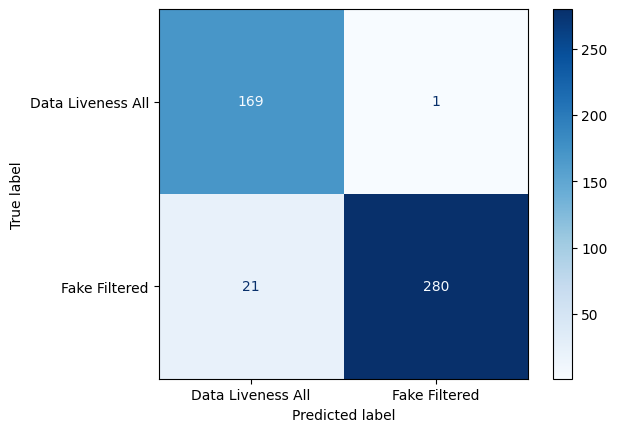

In [10]:
# Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
# Save the model
torch.save(model.state_dict(), "face_spoofing_mobilenet.pth")

dummy_input = torch.randn(1, 3, 224, 224, device=device)
onnx_program = torch.onnx.export(
    model,
    dummy_input,
    dynamo=True
)

onnx_program.save("image_classifier_model.onnx")

[torch.onnx] Obtain model graph for `FaceSpoofingModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `FaceSpoofingModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
